In [3]:
#计算结果一的阈值
from MyModel import Classification
from HaoChiUtils import DataAnalyzer as DA
import os
def get_result1_threshold(file_path="SuspectedDepressedUsers"):
    label_list=['快乐','恐惧','愤怒','惊讶','喜爱','厌恶','悲伤']
    
    weight_list=[-1,0.5,1,0,-1.5,0.5,1.3]
    # 初始化模型
    myClassification=Classification("bert_model")
    # 读取文本
    fir_list=os.listdir(file_path)
    total_result1=0
    for i in fir_list:
        data = DA.get_dataList(file_path+'/'+i,min_len=6)  # 获取文本数据
        # 预测
        pre=myClassification.get_predict_result(data)  # 使用模型进行预测
        res_dict=DA.calculate_label_proportions(pre,label_list=label_list)  # 计算预测结果中各标签的比例
        result1=0
        print("res_dict：",res_dict)
        for i in range(len(label_list)):
            result1=result1+res_dict[label_list[i]]*weight_list[i]*100  # 根据权重计算结果
        total_result1+=result1
    return total_result1/len(fir_list)*0.7  # 返回平均结果
res=get_result1_threshold()
print("结果1的阈值为:",res)

[2023-08-02 11:16:16,267] [    INFO] - Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "fuse": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "paddlenlp_version": null,
  "pool_act": "tanh",
  "type_vocab_size": 2,
  "vocab_size": 21128
}



[2023-08-02 11:16:18,373] [ WARNING] - Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.layer_norm.bias', 'cls.predictions.decoder_bias', 'cls.predictions.transform.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.weight', 'cls.predictions.layer_norm.weight', 'cls.predictions.decoder_weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-08-02 11:16:18,375] [ WARNING] - Some weights of BertForSequenceClassifi

res_dict： {'快乐': 0.04, '恐惧': 0.0, '愤怒': 0.08, '惊讶': 0.04, '喜爱': 0.02, '厌恶': 0.06, '悲伤': 0.76}
res_dict： {'快乐': 0.06, '恐惧': 0.02, '愤怒': 0.02, '惊讶': 0.0, '喜爱': 0.05, '厌恶': 0.01, '悲伤': 0.84}
res_dict： {'快乐': 0.08, '恐惧': 0.01, '愤怒': 0.07, '惊讶': 0.0, '喜爱': 0.03, '厌恶': 0.05, '悲伤': 0.75}
res_dict： {'快乐': 0.13, '恐惧': 0.0, '愤怒': 0.0, '惊讶': 0.02, '喜爱': 0.04, '厌恶': 0.08, '悲伤': 0.73}
res_dict： {'快乐': 0.13, '恐惧': 0.01, '愤怒': 0.02, '惊讶': 0.0, '喜爱': 0.08, '厌恶': 0.01, '悲伤': 0.74}
res_dict： {'快乐': 0.09, '恐惧': 0.0, '愤怒': 0.12, '惊讶': 0.03, '喜爱': 0.03, '厌恶': 0.03, '悲伤': 0.7}
res_dict： {'快乐': 0.13, '恐惧': 0.02, '愤怒': 0.03, '惊讶': 0.0, '喜爱': 0.06, '厌恶': 0.14, '悲伤': 0.63}
res_dict： {'快乐': 0.13, '恐惧': 0.08, '愤怒': 0.03, '惊讶': 0.01, '喜爱': 0.07, '厌恶': 0.03, '悲伤': 0.65}
res_dict： {'快乐': 0.09, '恐惧': 0.02, '愤怒': 0.02, '惊讶': 0.0, '喜爱': 0.02, '厌恶': 0.13, '悲伤': 0.72}
res_dict： {'快乐': 0.15, '恐惧': 0.0, '愤怒': 0.18, '惊讶': 0.0, '喜爱': 0.09, '厌恶': 0.0, '悲伤': 0.58}
res_dict： {'快乐': 0.11, '恐惧': 0.0, '愤怒': 0.14, '惊讶': 0.0, '喜爱': 

In [4]:
import math
from MyModel import Classification
from HaoChiUtils import DataAnalyzer as DA
import os
#计算判断熵率高低的阈值
def get_Entropy_threshold(file_path="SuspectedDepressedUsers"):
    label_list=['快乐','恐惧','愤怒','惊讶','喜爱','厌恶','悲伤']
    label_dict = {label: 0 for label in label_list}
    # 初始化模型
    myClassification=Classification("bert_model")
    # 读取文本
    fir_list=os.listdir(file_path)
    # total_result1=0
    for i in fir_list:
        data = DA.get_dataList(file_path+'/'+i,min_len=6)  # 获取文本数据
        # 预测
        pre=myClassification.get_predict_result(data)  # 使用模型进行预测
        res_dict=DA.calculate_label_proportions(pre,label_list=label_list)  # 计算预测结果中各标签的比例
        # result1=0
        print("res_dict：",res_dict)
        for i in range(len(label_list)):
            label_dict[label_list[i]]+=res_dict[label_list[i]]
        # total_result1+=result1
    for i in label_dict.keys():
        label_dict[i]=label_dict[i]/(len(fir_list))
    total_pi=0
    for i in label_list:
        if i =='惊讶':
            continue
        pi=label_dict[i]
        total_pi+=-pi*math.log2(pi)
    return total_pi/20
res=get_Entropy_threshold()
print("熵率的阈值 = ",res)

[2023-08-02 11:16:43,200] [    INFO] - Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "fuse": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "paddlenlp_version": null,
  "pool_act": "tanh",
  "type_vocab_size": 2,
  "vocab_size": 21128
}

[2023-08-02 11:16:44,417] [ WARNING] - Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions

res_dict： {'快乐': 0.04, '恐惧': 0.0, '愤怒': 0.08, '惊讶': 0.04, '喜爱': 0.02, '厌恶': 0.06, '悲伤': 0.76}
res_dict： {'快乐': 0.06, '恐惧': 0.02, '愤怒': 0.02, '惊讶': 0.0, '喜爱': 0.05, '厌恶': 0.01, '悲伤': 0.84}
res_dict： {'快乐': 0.08, '恐惧': 0.01, '愤怒': 0.07, '惊讶': 0.0, '喜爱': 0.03, '厌恶': 0.05, '悲伤': 0.75}
res_dict： {'快乐': 0.13, '恐惧': 0.0, '愤怒': 0.0, '惊讶': 0.02, '喜爱': 0.04, '厌恶': 0.08, '悲伤': 0.73}
res_dict： {'快乐': 0.13, '恐惧': 0.01, '愤怒': 0.02, '惊讶': 0.0, '喜爱': 0.08, '厌恶': 0.01, '悲伤': 0.74}
res_dict： {'快乐': 0.09, '恐惧': 0.0, '愤怒': 0.12, '惊讶': 0.03, '喜爱': 0.03, '厌恶': 0.03, '悲伤': 0.7}
res_dict： {'快乐': 0.13, '恐惧': 0.02, '愤怒': 0.03, '惊讶': 0.0, '喜爱': 0.06, '厌恶': 0.14, '悲伤': 0.63}
res_dict： {'快乐': 0.13, '恐惧': 0.08, '愤怒': 0.03, '惊讶': 0.01, '喜爱': 0.07, '厌恶': 0.03, '悲伤': 0.65}
res_dict： {'快乐': 0.09, '恐惧': 0.02, '愤怒': 0.02, '惊讶': 0.0, '喜爱': 0.02, '厌恶': 0.13, '悲伤': 0.72}
res_dict： {'快乐': 0.15, '恐惧': 0.0, '愤怒': 0.18, '惊讶': 0.0, '喜爱': 0.09, '厌恶': 0.0, '悲伤': 0.58}
res_dict： {'快乐': 0.11, '恐惧': 0.0, '愤怒': 0.14, '惊讶': 0.0, '喜爱': 

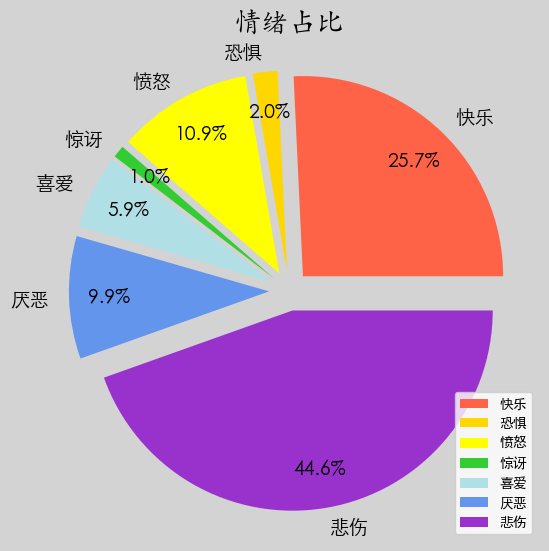

In [10]:
#画饼状图
import matplotlib.pyplot as plt                #导入绘图包
from matplotlib import font_manager as fm
from matplotlib import cm
import numpy as np
import os
plt.rcParams['font.sans-serif'] = ['SimHei']   #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决中文显示问题

pro_dict = {'快乐': 0.26, '恐惧': 0.02, '愤怒': 0.11, '惊讶': 0.01, '喜爱': 0.06, '厌恶': 0.1, '悲伤': 0.45}

labels = list(pro_dict.keys())
probs = list(pro_dict.values())
# 悲伤：#9932CC 厌恶：#6495ED 喜爱： #B0E0E6 惊讶：#32CD32 愤怒：#FFFF00 恐惧：#FFD700 快乐：#FF6347
# 自定义颜色列表
colors = ['#FF6347', '#FFD700', '#FFFF00', '#32CD32', '#B0E0E6', '#6495ED', '#9932CC']
# colors = ['red', 'orange', 'yellow', 'violet', 'blue', 'indigo','green']
# colors = cm.GnBu(np.arange(len(labels),0,-2) / len(labels))
# 自定义偏移量列表
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plt.figure(figsize=(10, 6.5),facecolor='lightgray')
# 设置标签字体属性
plt.pie(probs, labels=labels,pctdistance=0.8, autopct='%1.1f%%', colors=colors,textprops={'fontsize': 14,'fontfamily':'STXihei'},explode=explode)
plt.title('情绪占比',fontsize=20,fontfamily='KaiTi')

plt.legend(loc='lower right')
# 定义文件夹路径和文件名
folder_path = "情绪占比饼状图"
png_name = "example"

# 创建文件夹
os.makedirs(folder_path, exist_ok=True)

# 保存图像
# plt.savefig(os.path.join(folder_path, png_name + '.png'))
plt.show()


Text(0, 0.5, '风\n险\n等\n级')

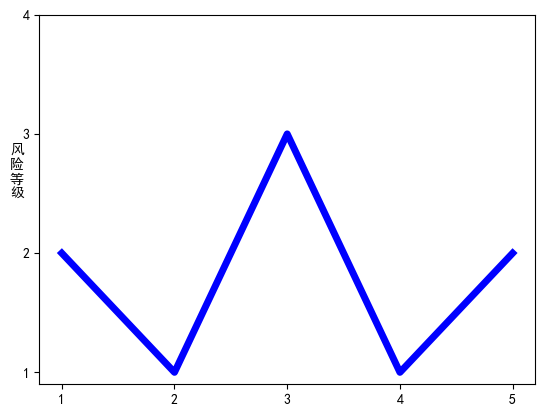

In [20]:
import matplotlib.pyplot as plt                #导入绘图包
from matplotlib import font_manager as fm
from matplotlib import cm
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei']   #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决中文显示问题
import os
x=[1,2,3,4,5]
y=[2,1,3,1,2]
plt.plot(x,y,color='b',linewidth=5)
plt.xticks([1,2,3,4,5])
plt.yticks([1,2,3,4])
plt.ylabel("风\n险\n等\n级",rotation=0)

In [3]:
import re

def replace_punctuation_with_space(text):
    # 定义正则表达式模式，匹配标点符号
    pattern = r'[^\w\s]'
    
    # 使用re.sub()函数将标点符号替换为空格
    new_text = re.sub(pattern, ' ', text)
    
    return new_text

# 测试代码
text = "Hello，world。》好？‘】 How are you?"
new_text = replace_punctuation_with_space(text)
print(new_text)

Hello world  好    How are you 
